# Расчет распространения излучения. **Angular Spectrum Method**

Хороший туториал по расчету дифракции: https://rafael-fuente.github.io
Рассмотрим задачу:

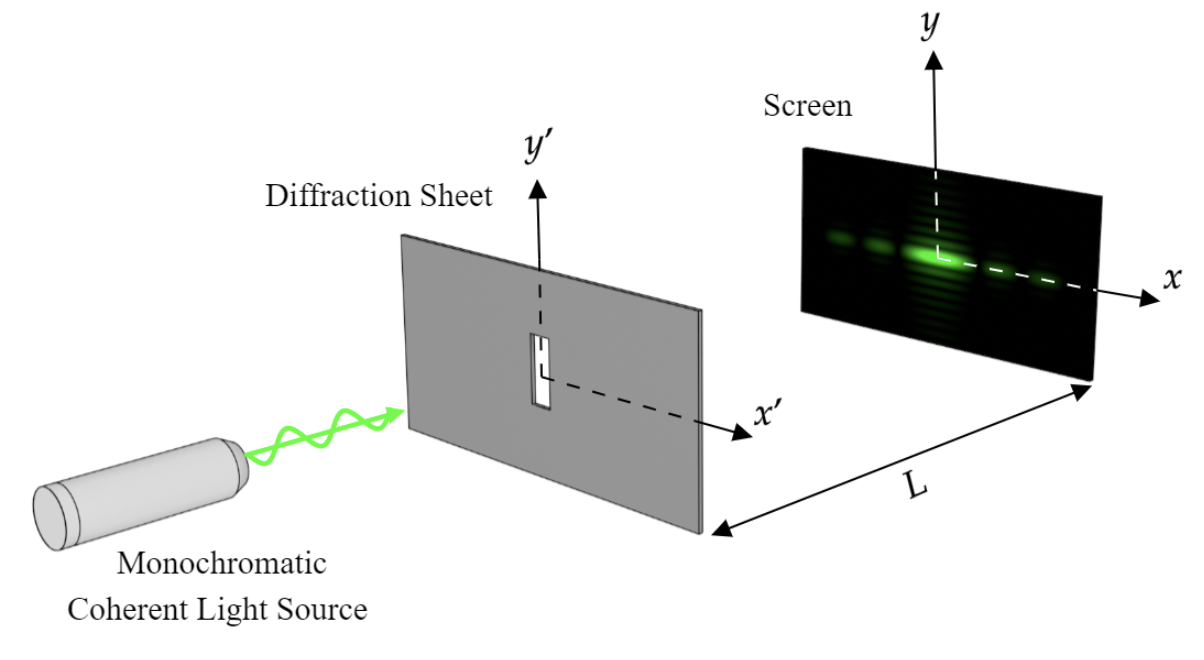

Наша задача найти распределение поля $U(x,y,L)$ в плоскости экрана по заданному распределению поля $U(x',y',0)$. Для этого запишем волновое уравнение в скалярном приближении:
\begin{equation}
\nabla^{2} U+k^{2} U=0, \quad k=\frac{2 \pi}{\lambda}
\end{equation}

Теперь, если мы применим перобразование Фурье к начальному распределению поля:
\begin{equation}
U(x, y, 0)=\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} A\left(k_{x}, k_{y} ; 0\right) e^{i\left(k_{x} x+k_{y} y\right)} \mathrm{~d} k_{x} \mathrm{~d} k_{y}
\end{equation}

$A$ - угловой спектр излучения:
\begin{equation}
A\left(k_{x}, k_{y} ; 0\right)=\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} U(x, y, 0) e^{-i\left(k_{x} x+k_{y} y\right)} \mathrm{~d} x \mathrm{dy}
\end{equation}

Подставляя выражение $U(x, y, z)$ через угловой спектр в волновое уравнение, получим:

\begin{equation}
\frac{d^{2}}{d z^{2}} A+k_{z} A=0 \quad \text { with } \quad k_{z}=\sqrt{k^{2}-k_{x}^{2}+k_{y}^{2}}
\end{equation}

Это уравнение имеет простое решение:

\begin{equation}
A\left(k_{x}, k_{y} ; z\right)=A\left(k_{x}, k_{y} ; 0\right) e^{-i k_{z} z}
\end{equation}

Тогда искомое распределение поля $U(x, y, L)$:
\begin{equation}
U(x, y,L)=\int_{-\infty}^{\infty} \int_{-\infty}^{\infty} A\left(k_{x}, k_{y} ; 0\right) e^{i k_{z} L} e^{\left(k_{x} x+k_{y} y\right) i} \mathrm{~d} k_{x} \mathrm{~d} k_{y}
\end{equation}

# Реализация на PyTorch

In [ ]:
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader

In [ ]:
class DiffractiveLayer(torch.nn.Module):

    def __init__(self, λ = 532e-9, N_pixels = 400, pixel_size = 20e-6, dz = 0.01):
        super(DiffractiveLayer, self).__init__()

        fx = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fy = np.fft.fftshift(np.fft.fftfreq(N_pixels, d = pixel_size))
        fxx, fyy = np.meshgrid(fx, fy)

        argument = (2 * np.pi)**2 * ((1. / λ) ** 2 - fxx ** 2 - fyy ** 2)

        #Calculate the propagating and the evanescent (complex) modes
        tmp = np.sqrt(np.abs(argument))
        kz = torch.tensor(np.where(argument >= 0, tmp, 1j*tmp))
        self.phase = torch.exp(1j * kz * dz).to(device)

    def forward(self, E):
        # waves (batch, 200, 200)
        fft_c = torch.fft.fft2(E)
        c = torch.fft.fftshift(fft_c)
        angular_spectrum = torch.fft.ifft2(torch.fft.ifftshift(c * self.phase))
        return angular_spectrum

def propagation_along_z(initial_field, wl, N_pixels, pixel_size, z_step, number_of_z_steps):
  diffraction_step = DiffractiveLayer(dz = z_step, λ = wl, N_pixels = N_pixels, pixel_size = pixel_size)
  z_ind = np.arange(0, number_of_z_steps)
  cross_section_profile = torch.zeros((len(z_ind), N_pixels))
  full_cross_section =  torch.zeros((len(z_ind),N_pixels, N_pixels),dtype = torch.complex64)
  full_cross_section[0] = torch.tensor(initial_field)
  with torch.no_grad():
    for ind in z_ind[1:]:
      full_cross_section[ind] = diffraction_step(full_cross_section[ind-1])
  return torch.abs(full_cross_section[:,N_pixels//2])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [ ]:
BEAM_SIZE = 50e-6
DISCRETIZATION_STEP = 1.0e-6
N_pixels = 800
z_step = 10e-6
number_of_z_steps = 500
z = np.arange(0, number_of_z_steps)*z_step
wl = 532e-9
coord_limit = (N_pixels//2)*DISCRETIZATION_STEP
mesh = np.arange(-coord_limit, coord_limit, DISCRETIZATION_STEP)
x, y = np.meshgrid(mesh, mesh)

# Примеры распространения поля

Распространение гауссова пучка шириной 10 мкм. Хорошо видно, что пучок сильно расходится

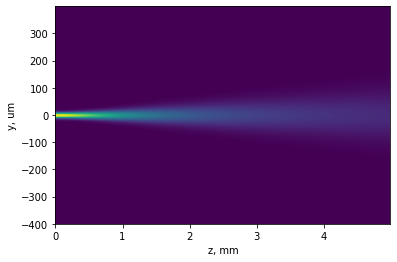

In [ ]:
BEAM_SIZE = 10e-6
beam = np.exp(-(x**2+y**2)/BEAM_SIZE**2)
field = propagation_along_z(beam, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.pcolormesh(z*10**3, mesh*10**6, field.T)
plt.xlabel('z, mm')
plt.ylabel('y, um')
plt.show()

Распространение гауссова пучка шириной 50 мкм. Такой широкий пучок почти не расходится

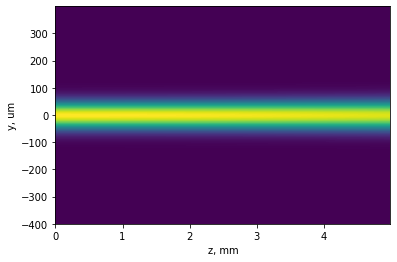

In [ ]:
BEAM_SIZE = 50e-6
beam = np.exp(-(x**2+y**2)/BEAM_SIZE**2)
field = propagation_along_z(beam, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.pcolormesh(z*10**3, mesh*10**6, field.T)
plt.xlabel('z, mm')
plt.ylabel('y, um')
plt.show()

Если мы хотим рассчитать распространение излучения после линзы, то нам нужно рассчитать какую фазовую модуляцию вносит линза:
\begin{equation}
T(x, y)=e^{-i \frac{k}{2 f}\left(x^{2}+y^{2}\right)}
\end{equation}

Далее мы просто считаем, что у нас есть поле $U(x,y,0)*T(x, y)$ и мы проделываем операции, описанные выше. Если рассмотрим тот же самый пучок, что был выше, то после линзы наблюдается фокусировка.

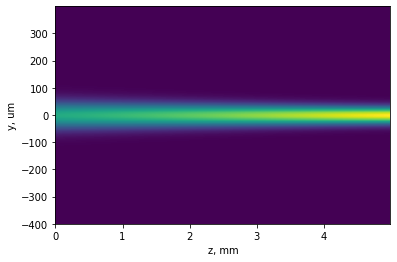

In [ ]:
BEAM_SIZE = 50e-6
f = 1e-2
beam = np.exp(-(x**2+y**2)/BEAM_SIZE**2)*np.exp(-1j*np.pi/(wl*f) * (x**2 + y**2))
field = propagation_along_z(beam, wl, N_pixels, DISCRETIZATION_STEP, z_step, number_of_z_steps)

plt.pcolormesh(z*10**3, mesh*10**6, field.T)
plt.xlabel('z, mm')
plt.ylabel('y, um')
plt.show()

# Дифракционная сеть

В качестве исходной архитектуры выбирал сеть из статьи Science:
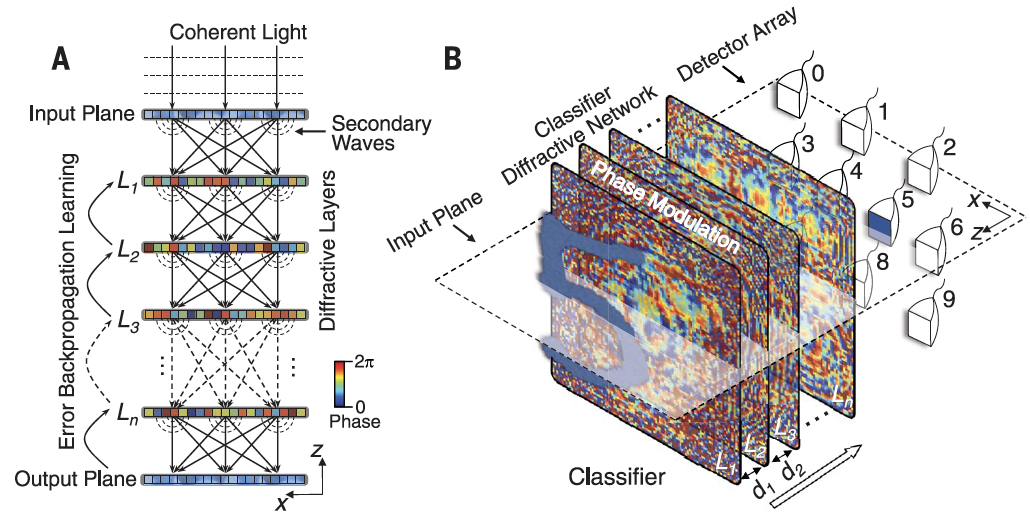

В итоге, схема расчета выглядит следующим образом:

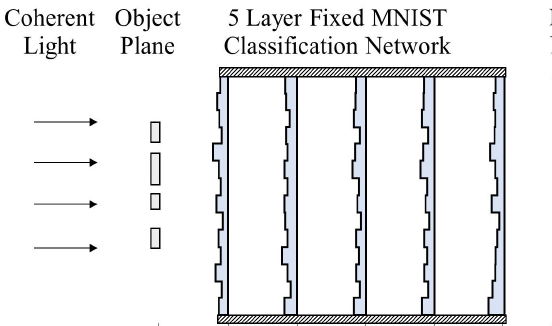

То есть у нас некоторое входное распределние поля и мы считаем распространние поля методом, описанным выше. При этом у нас есть 5 отдельных независимых фазовых масок.

Для работы в видимом диапазоне были выбраны следующие параметры:

Длина волны $\lambda = 532$ нм

Размер одного пикспеля фазовой маски $dx = dy = 15$ мкм

Количество пикселей в маске $N_x = N_y = 400$

Количество фазовых масок (слоев) $N = 5$

Расстояние между слоями $d = 10$ см



# Реализация модели дифракционной сети на PyTorch

In [ ]:
class DNN(torch.nn.Module):
    """
    phase only modulation
    """
    def __init__(self, num_layers=5, wl = 532e-9, N_pixels = 400, pixel_size = 20e-6, distance = 0.01, lens_focus = 10e-2):

        super(DNN, self).__init__()
        
        self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).astype('float32')-0.5)) for _ in range(num_layers)]
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), self.phase[i])

        coord_limit = (N_pixels//2)*pixel_size 
        mesh = np.arange(-coord_limit, coord_limit, pixel_size)
        x, y = np.meshgrid(mesh, mesh)    
        
        self.diffractive_layers = torch.nn.ModuleList([DiffractiveLayer(wl, N_pixels, pixel_size, distance) for _ in range(num_layers)])
        self.last_diffractive_layer = DiffractiveLayer(wl, N_pixels, pixel_size, distance)

    def forward(self, x):
        # x (batch, N_pixels, N_pixels)
        
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(x)
            constr_phase = 2*np.pi*torch.sigmoid(self.phase[index])
            exp_j_phase = torch.exp(1j*constr_phase)
            x = temp * exp_j_phase
        x = self.last_diffractive_layer(x)
        
        x_abs = torch.abs(x)**2
        return x_abs
        #output = detector_region(x_abs)
        #return output, x_abs

In [ ]:
# MNIST датасет
BATCH_SIZE=128
IMG_SIZE = 28 * 5
N_pixels = 400
PADDING = (N_pixels - IMG_SIZE) // 2

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE,IMG_SIZE))])
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [ ]:
def visualize(model, example):
  ex = F.pad(example[0], pad=(PADDING, PADDING, PADDING, PADDING))
  out = model(ex.to(device))
  plt.subplot(1,2,1)
  plt.imshow(ex[0], interpolation='none')
  plt.title(f'Input image with label {example[1]}')
  output_image = out.detach().cpu()[0]
  plt.subplot(1,2,2)
  plt.imshow(output_image, interpolation='none')
  plt.title(f'Output image')
  #plt.colorbar()
  plt.show()

def mask_visualiztion(model):
  for ind, mask in enumerate(model.phase):
    plt.imshow(torch.sigmoid(mask.detach().cpu())*360, interpolation = 'none')
    #plt.imshow(mask.detach().cpu()*180/np.pi, interpolation='none')
    plt.title(f'Mask of layer {ind+1}')
    plt.colorbar()
    plt.show()

def phase_to_dz(phase, dn, wl):
  return wl*phase/2/np.pi/dn

In [ ]:
model = torch.load('MNIST_0.74.pth', map_location=device)

# Визуализация работы сети

В итоге, обученная сеть способна классифицировать рукописные цифры с точностью 73%. Ниже пример работы сети на случаных примерах из тестового датасета.

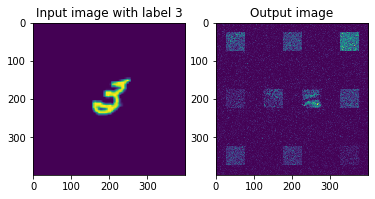

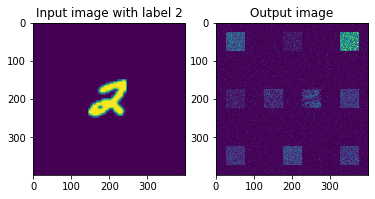

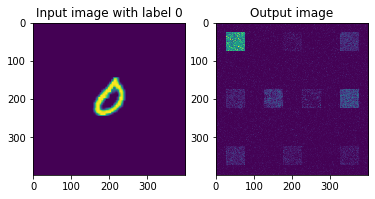

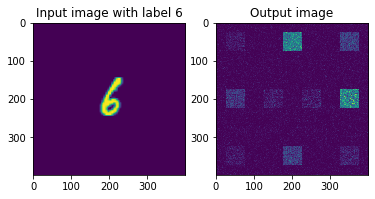

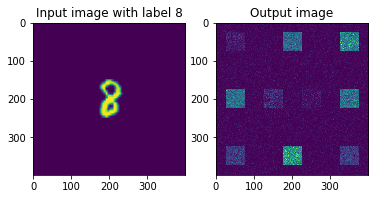

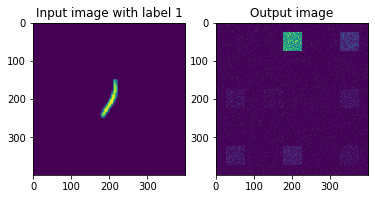

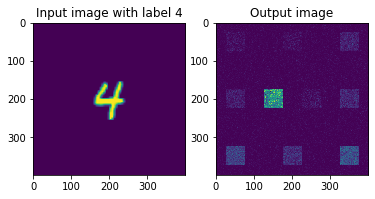

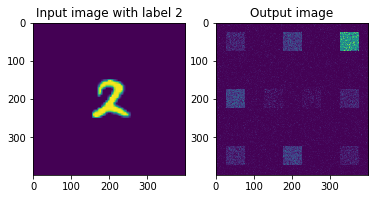

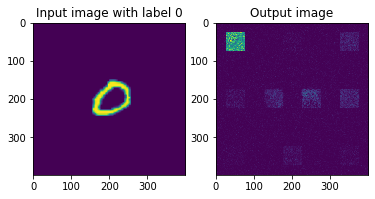

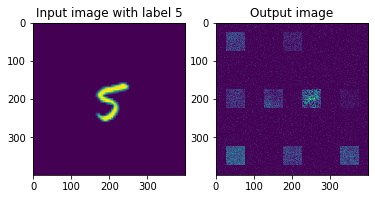

In [ ]:
rand_ind = np.random.choice(range(len(val_dataset)), size=10, replace=False)
for ind in rand_ind:
  visualize(model, val_dataset[ind])

Вот так выглядят фазовые маски:

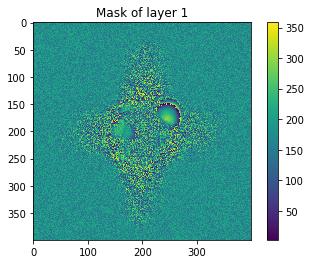

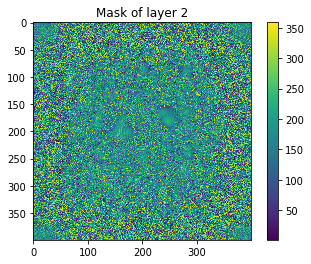

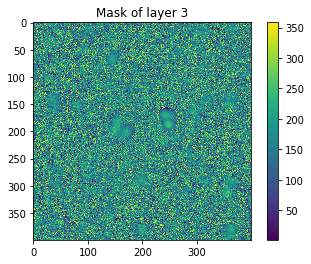

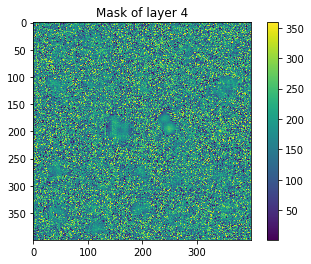

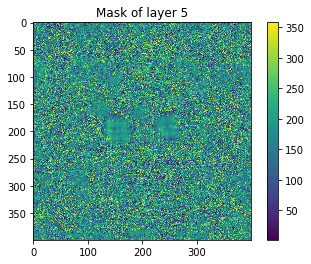

In [ ]:
mask_visualiztion(model)

Можем пересчитать эти фазовые маски в толщину полимерной пленки. Если мы погрузим резист с показателем преломления 1.46 в спирт, то нужно уметь изменять высоту пленки резиста от 0 до 5 мкм.

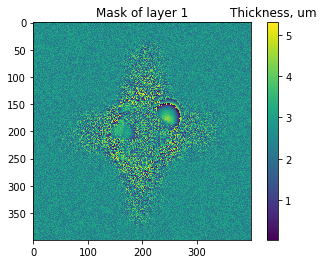

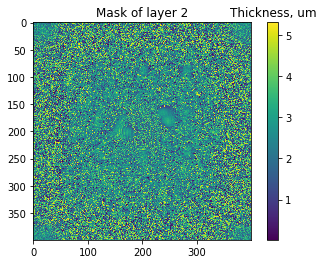

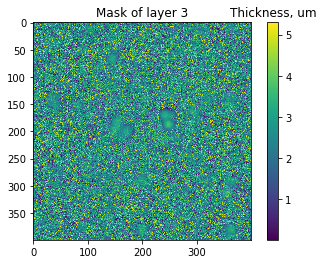

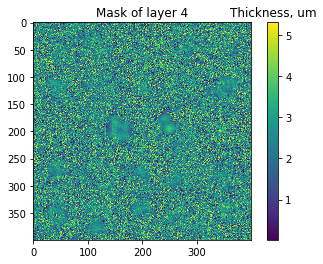

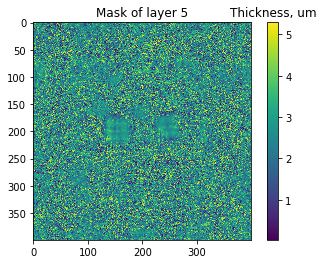

In [ ]:
n_esun = 1.46
n_formlabs = 1.56
n_alc = 1.36

dn = n_esun-n_alc 

for ind, mask in enumerate(model.phase):
    phase = 2*np.pi*torch.sigmoid(mask.detach().cpu())
    plt.imshow(phase_to_dz(phase, dn, wl)*10**6, interpolation = 'none')
    #plt.imshow(mask.detach().cpu()*180/np.pi, interpolation='none')
    plt.title(f'Mask of layer {ind+1}')
    clb =plt.colorbar()
    clb.ax.set_title('Thickness, um')
    plt.show()

# Фурье дифракционная сеть

Также я попробовал обучить дифракционную сеть с фурье преобразованием. Для этого я использовал архитектуру из работы "Fourier-space Diffractive Deep Neural Network":


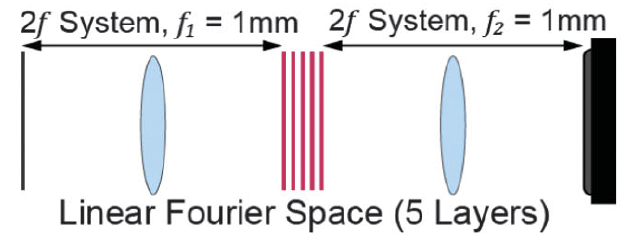

Для работы в видимом диапазоне были выбраны следующие параметры:

Длина волны $\lambda = 532$ нм

Размер одного пикспеля фазовой маски $dx = dy = 10$ мкм

Количество пикселей в маске $N_x = N_y = 400$

Количество фазовых масок (слоев) $N = 5$

Расстояние между слоями $d = 4$ мм

Две линзы с $f = 100$ мм

# Реализация дифракционной сети с фурье преобразованием

In [ ]:
class Fourier_DNN(torch.nn.Module):
    """
    phase only modulation
    """
    def __init__(self, num_layers=5, wl = 532e-9, N_pixels = 400, pixel_size = 20e-6, distance = 0.01, lens_focus = 10e-2):

        super(Fourier_DNN, self).__init__()
        
        #self.phase = [torch.nn.Parameter(torch.from_numpy(np.random.random(size=(N_pixels, N_pixels)).astype('float32')-0.5)) for _ in range(num_layers)]
        self.phase = [torch.nn.Parameter(torch.from_numpy(np.zeros((N_pixels, N_pixels)).astype('float32'))) for _ in range(num_layers)]
        for i in range(num_layers):
            self.register_parameter("phase" + "_" + str(i), self.phase[i])

        coord_limit = (N_pixels//2)*pixel_size 
        mesh = np.arange(-coord_limit, coord_limit, pixel_size)
        x, y = np.meshgrid(mesh, mesh)    
        self.lens_phase = torch.tensor(np.exp(-1j*np.pi/(wl*2*lens_focus) * (x**2 + y**2)), device = device)
        self.first_diffractive_layer = DiffractiveLayer(wl, N_pixels, pixel_size, lens_focus-distance)
        self.diffractive_layers = torch.nn.ModuleList([DiffractiveLayer(wl, N_pixels, pixel_size, distance) for _ in range(0,num_layers)])
        self.double_f_layer = DiffractiveLayer(wl, N_pixels, pixel_size, 2*lens_focus)
        self.single_f_layer = DiffractiveLayer(wl, N_pixels, pixel_size, lens_focus)
        self.sofmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        # x (batch, 200, 200)
        outputs = []
        outputs.append(x)
        #x = self.double_f_layer(x)
        x = self.single_f_layer(x)
        outputs.append(x)
        x = x*self.lens_phase
        x = self.first_diffractive_layer(x)
        for index, layer in enumerate(self.diffractive_layers):
            temp = layer(x)
            outputs.append(x)
            #constr_phase = self.phase[index]#
            constr_phase = np.pi*torch.sigmoid(self.phase[index])
            exp_j_phase = torch.exp(1j*constr_phase)#torch.cos(constr_phase)+1j*torch.sin(constr_phase)
            x = temp * exp_j_phase
        x = self.single_f_layer(x)
        outputs.append(x)
        x = x*self.lens_phase
        #x = self.double_f_layer(x)
        x = self.single_f_layer(x)
        outputs.append(x)
        # x_abs (batch, 200, 200)
        x_abs = torch.abs(x)**2
        return x_abs, outputs
        #output = detector_region(x_abs)
        #return output, x_abs, outputs

In [ ]:
BATCH_SIZE=128
IMG_SIZE = 28 * 3
N_pixels = 400
PADDING = (N_pixels - IMG_SIZE) // 2

transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((IMG_SIZE,IMG_SIZE))])
train_dataset = torchvision.datasets.MNIST("./data", train=True, transform=transform, download=True)
val_dataset = torchvision.datasets.MNIST("./data", train=False, transform=transform, download=True)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def prop_vis_abs(model, example):
  ex = F.pad(example, pad=(PADDING, PADDING, PADDING, PADDING))
  _, imgs = fourier_model(ex.to(device))
  names = ['Initial', 'Before lens', 'Before mask 1',
           'Before mask 2', 'Before mask 3', 'Before mask 4',
           'Before mask 5', 'Before second lens', 'End']
  for img, name in zip(imgs, names):
    plt.imshow(img[0].abs().detach().cpu()**2)
    plt.title(name)
    plt.show()

In [ ]:
def visualize(model, example):
  ex = F.pad(example[0], pad=(PADDING, PADDING, PADDING, PADDING))
  out = model(ex.to(device))
  plt.subplot(1,2,1)
  plt.imshow(ex[0], interpolation='none')
  plt.title(f'Input image with label {example[1]}')
  output_image = out[0].detach().cpu()[0]
  plt.subplot(1,2,2)
  plt.imshow(output_image, interpolation='none')
  plt.title(f'Output image')
  #plt.colorbar()
  plt.show()

In [ ]:
fourier_model = torch.load('Fourier_MNIST_0.77.pth', map_location=device)

# Визуализация работы сети с Фурье-преобразованием

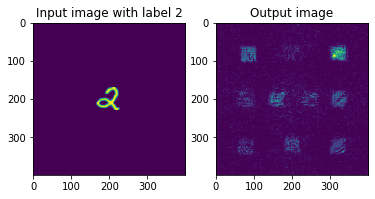

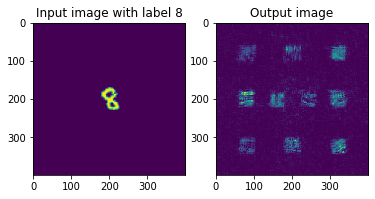

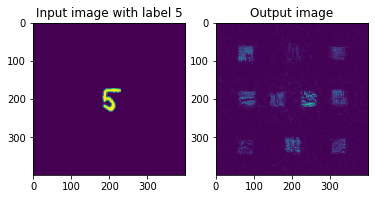

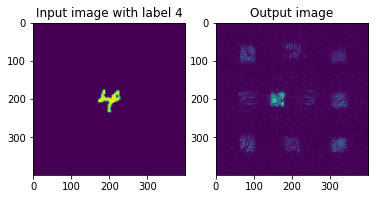

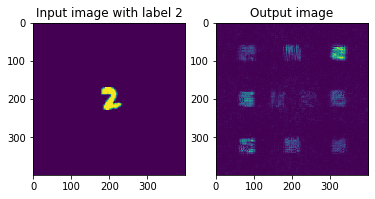

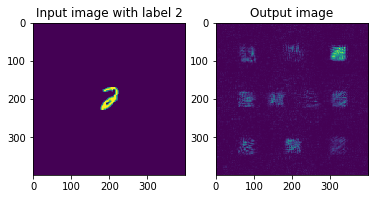

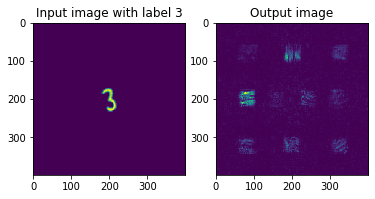

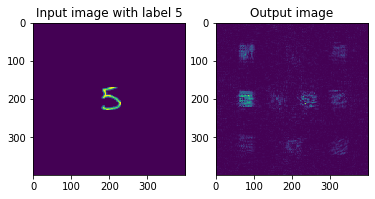

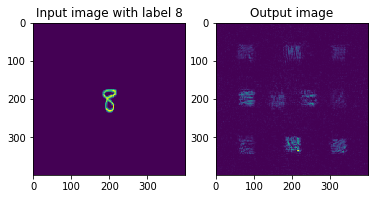

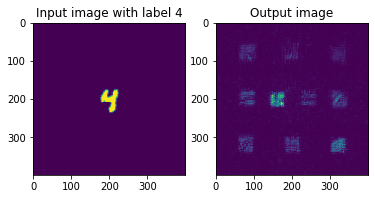

In [ ]:
rand_ind = np.random.choice(range(len(val_dataset)), size=10, replace=False)
for ind in rand_ind:
  visualize(fourier_model, val_dataset[ind])

Визуализация масок

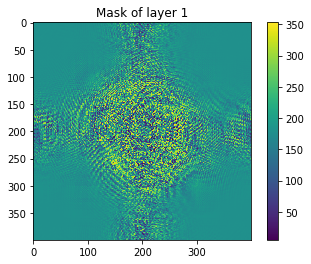

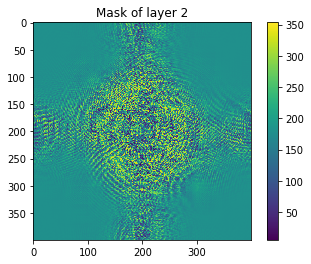

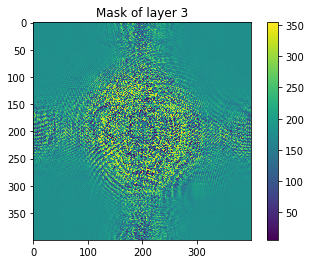

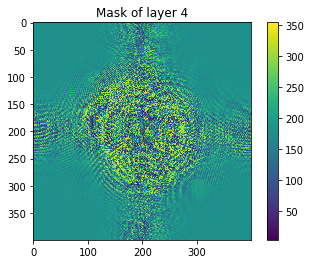

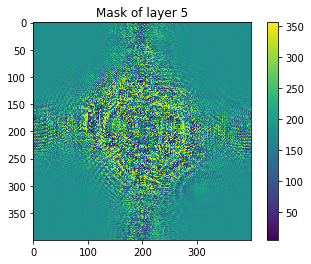

In [ ]:
mask_visualiztion(fourier_model)

Наглядная демонстрация распространения излучения в сети

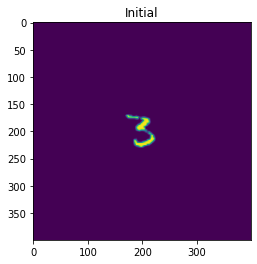

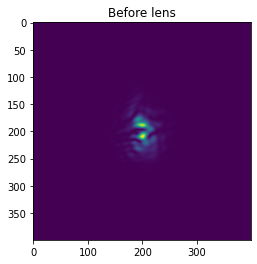

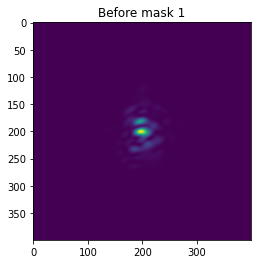

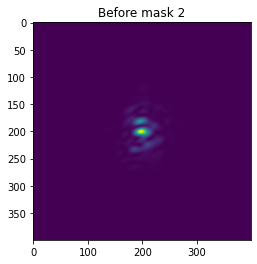

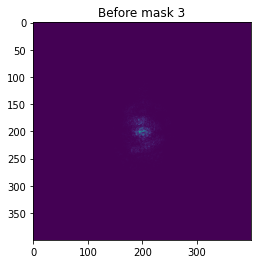

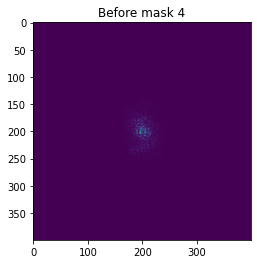

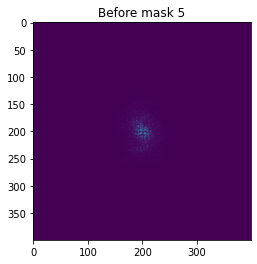

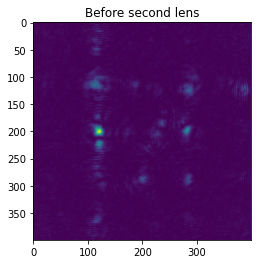

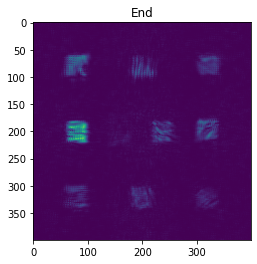

In [ ]:
rand_ind = np.random.choice(range(len(val_dataset)), size=1, replace=False)
prop_vis_abs(model, val_dataset[rand_ind[0]][0])

А вот так выглядит фурье преобразование от входа

In [ ]:
ex = val_dataset[rand_ind[0]][0]
fft_c = torch.fft.fft2(ex)
c = torch.fft.fftshift(fft_c)

Text(0.5, 1.0, 'Fourier')

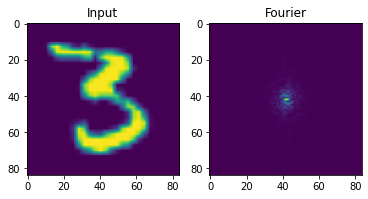

In [ ]:
plt.subplot(1,2,1)
plt.imshow(ex[0])
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(c.abs()[0])
plt.title('Fourier')

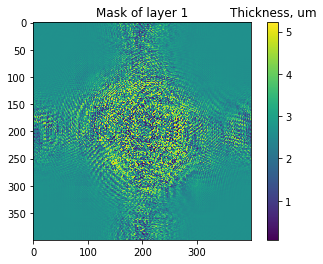

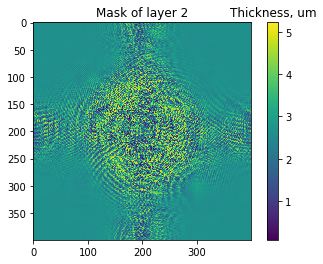

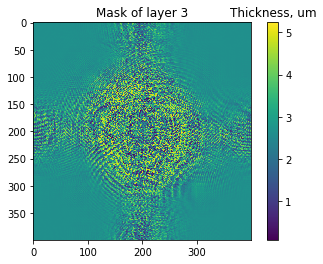

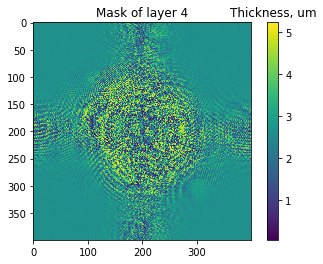

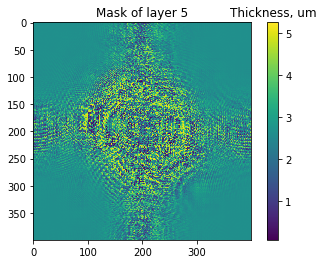

In [ ]:
n_esun = 1.46
n_formlabs = 1.56
n_alc = 1.36

dn = n_esun-n_alc 

for ind, mask in enumerate(fourier_model.phase):
    phase = 2*np.pi*torch.sigmoid(mask.detach().cpu())
    plt.imshow(phase_to_dz(phase, dn, wl)*10**6, interpolation = 'none')
    #plt.imshow(mask.detach().cpu()*180/np.pi, interpolation='none')
    plt.title(f'Mask of layer {ind+1}')
    clb =plt.colorbar()
    clb.ax.set_title('Thickness, um')
    plt.show()

Возможные пути повышения точности работы:

1. Малое число слоев сети. Увеличение количества слоев позволит повысить точность на 5-10%.

2. Добавление амлитудной маски также должно повысить точность.

3. Возможно, размер одного пикселя слишком большой. Возможно, требуется оптимизация расстояния между слоями.

4. Стоит провести более детальное исследование зависимости точности классификации от гиперпараметров